# Lyapunov Analysis with clvlib

This notebook demonstrates how to compute Lyapunov exponents, backward/covariant Lyapunov vectors, their angles
and instantaneous covariant Lyapunov exponents (ICLEs) for the Lorenz '63 system using `clvlib.numpy`.


## Prerequisites

Ensure `clvlib` is installed in your environment (see the project README for installation instructions).
This walkthrough relies only on NumPy, SciPy, and Matplotlib.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from clvlib.numpy import lyap_analysis_from_ic, compute_angles, principal_angles, compute_ICLE, lyap_analysis


## Define the Lorenz '63 system

We work with the classical chaotic Lorenz attractor and its analytical Jacobian.


In [3]:
SIGMA = 10.0
RHO = 28.0
BETA = 8.0 / 3.0

def lorenz(t: float, x: np.ndarray) -> np.ndarray:
    return np.array([
        SIGMA * (x[1] - x[0]),
        x[0] * (RHO - x[2]) - x[1],
        x[0] * x[1] - BETA * x[2],
    ], dtype=float)

def jacobian(t: float, x: np.ndarray) -> np.ndarray:
    return np.array([
        [-SIGMA, SIGMA, 0.0],
        [RHO - x[2], -1.0, -x[0]],
        [x[1], x[0], -BETA],
    ], dtype=float)


## Integrate state and variational equations

`lyap_analysis_from_ic` integrates the trajectory and variational system simultaneously, returning
Lyapunov exponent estimates, backward Lyapunov vectors (BLVs), CLVs, and the trajectory samples.


In [4]:
times = np.linspace(0.0, 40.0, 4001)  # 4000 integration steps
x0 = np.array([8.0, 0.0, 30.0], dtype=float)

LE, LE_history, BLV_history, CLV_history, trajectory = lyap_analysis_from_ic(
    lorenz,
    jacobian,
    x0,
    times,
    stepper="rk4",
    qr_method="householder",
    ginelli_method="ginelli",
)

print("Asymptotic Lyapunov exponents:", LE)


Asymptotic Lyapunov exponents: [  0.87318906  -0.02318648 -14.51656772]


## Visualise the Lorenz attractor

/var/folders/gt/d_17lf9d0s7gwxpfpvh0g9nh0000gn/T/ipykernel_5002/2897692419.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


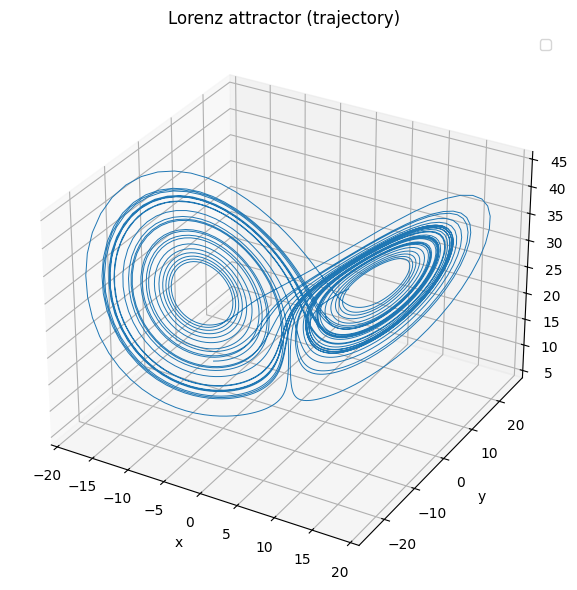

In [5]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x, y, z = trajectory.T
ax.plot(x, y, z, color='tab:blue', linewidth=0.7)

ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_title('Lorenz attractor (trajectory)')
ax.legend()
plt.tight_layout()
plt.show()

## Visualise the convergence of Lyapunov exponents

Plot each exponent as a function of time to check convergence behaviour.


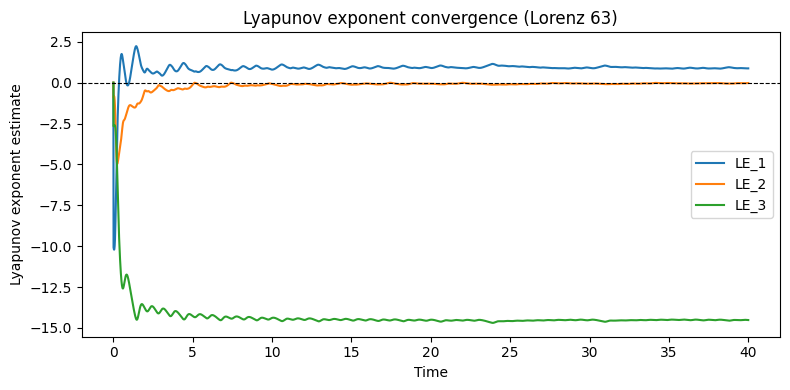

In [6]:
plt.figure(figsize=(8, 4))
for k in range(LE_history.shape[1]):
    plt.plot(times, LE_history[:, k], label=f'LE_{k + 1}')
plt.axhline(0.0, color='k', linewidth=0.8, linestyle='--')
plt.xlabel('Time')
plt.ylabel('Lyapunov exponent estimate')
plt.title('Lyapunov exponent convergence (Lorenz 63)')
plt.legend()
plt.tight_layout()
plt.show()


## Compute angles and instantaneous exponents


In [14]:
cosine, theta = compute_angles(CLV_history[:, :, 0], CLV_history[:, :, 1])
print('Angles between first and second CLVs (radians):', theta)

angles = principal_angles(CLV_history[:, :, :-1], CLV_history[:, :, -1:])
print('Principal angles shape:', angles.shape)

icle = compute_ICLE(jacobian, trajectory, times, CLV_history)
print('ICLE shape:', icle.shape)


Angles between first and second CLVs (radians): [2.91929555 2.91929555 2.89416738 ... 1.75950949 1.66563109 1.57079633]
Principal angles shape: (4001, 1)
ICLE shape: (4001, 3)


## Intermittent Error

When using Householder reflections to compute CLVs, we observe that the algorithm may converge to a solution that exhibits intermittent errors. Specifically, during the inversion of the tridiagonal matrix (following Ginelli’s algorithm), it is possible for $ R[i] $ to be computed in a *reflected* basis relative to the basis used to compute $ C[i+1] $.

As a result, the computed CLVs may undergo intermittent rotations with respect to the correct basis, which manifests as fluctuations in the CLV components.

To address this issue, we introduce an *upwind* modification to the Ginelli algorithm. Instead of using $ R[i] $, we replace it with $ R[i+1] $, ensuring that the projection is expressed in the same basis as $ C[i+1] $. This approximation remains valid as long as $ \Delta t $ is sufficiently small.

If it is not possible to ensure that $ \Delta t $ is sufficiently small (for example, due to memory constraints), we recommend using the Gram–Schmidt decomposition instead by setting `qr_method = 'gs'`. This QR decomposition is JIT-compiled to maintain good performance. However, keep in mind that Gram–Schmidt is generally less numerically stable than Householder reflections.



In [15]:
LE_upwind, LE_history_upwind, BLV_history_upwind, CLV_history_upwind = lyap_analysis(lorenz, jacobian, trajectory, times,
                                                                                      stepper="rk4",
                                                                                      qr_method="householder",
                                                                                      ginelli_method="upwind_ginelli")

In [16]:
cosine_upwind, theta_upwind = compute_angles(CLV_history_upwind[:, :, 0], CLV_history_upwind[:, :, 1])
print('Shape of angles between first and second CLVs (radians):', theta_upwind.shape)

angles_upwind = principal_angles(CLV_history_upwind[:, :, :-1], CLV_history_upwind[:, :, -1:])
print('Principal angles shape:', angles_upwind.shape)

icle_upwind = compute_ICLE(jacobian, trajectory, times, CLV_history_upwind)
print('ICLE shape:', icle.shape)

Shape of angles between first and second CLVs (radians): (4001,)
Principal angles shape: (4001, 1)
ICLE shape: (4001, 3)


## Comparing the solutions with upwind Ginelli and normal Ginelli

### Covariant Lyapunov vectors

Here we plot the entries of the third CLVs between `ginelli` and `upwind_ginelli`. It i possible to see how the upwind method corrects the intermittent overshoots due to the Householder reflections.

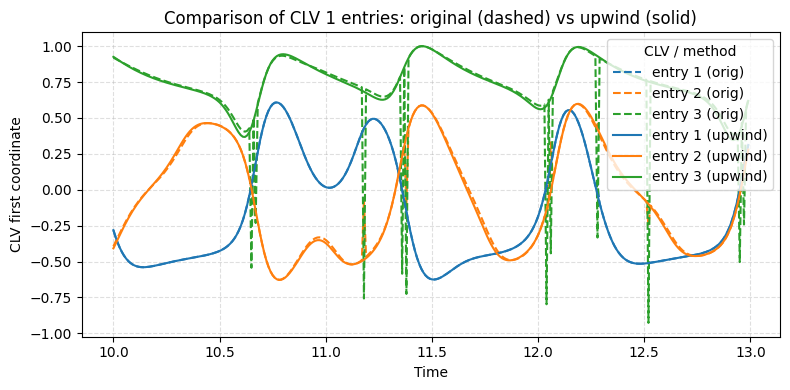

In [ ]:
plt.figure(figsize=(8, 4))

start, end = 1000, 1300

# plot original (dashed) and upwind (solid) CLV first-coordinate for three vectors
plt.plot(times[start:end], CLV_history[start:end, 0, 0], label='entry 1 (orig)', linestyle='--', color='C0')
plt.plot(times[start:end], CLV_history[start:end, 0, 1], label='entry 2 (orig)', linestyle='--', color='C1')
plt.plot(times[start:end], CLV_history[start:end, 0, 2], label='entry 3 (orig)', linestyle='--', color='C2')

plt.plot(times[start:end], CLV_history_upwind[start:end, 0, 0], label='entry 1 (upwind)', color='C0')
plt.plot(times[start:end], CLV_history_upwind[start:end, 0, 1], label='entry 2 (upwind)', color='C1')
plt.plot(times[start:end], CLV_history_upwind[start:end, 0, 2], label='entry 3 (upwind)', color='C2')

plt.xlabel('Time')
plt.ylabel('CLV first coordinate')
plt.title('Comparison of CLV 1 entries: original (dashed) vs upwind (solid)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='entry / method', loc='upper right')
plt.tight_layout()
plt.show()



### Angles

Here we look at angles between the first and second CLVs and the principal angle between the last and the first two. The overshoots are not present in the angle computaions. This is expected, as the rotations preverve the relative angles between CLVs.

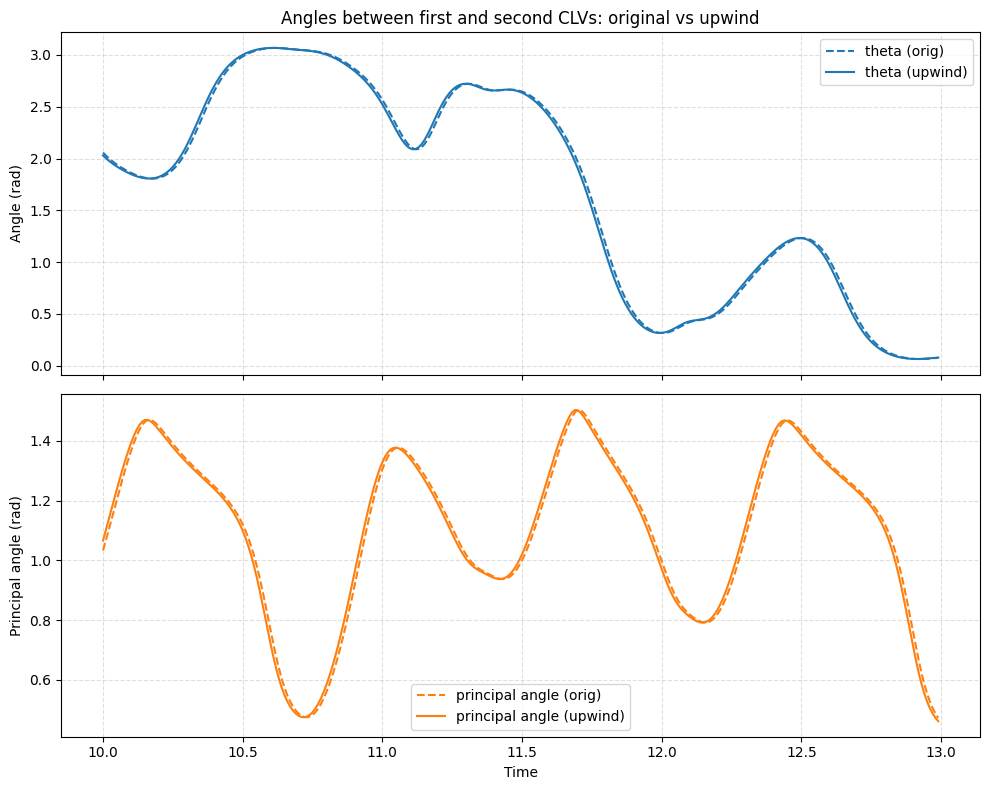

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# use the requested slice
ts = times[start:end]

# theta comparison
ax1.plot(ts, theta[start:end], label='theta (orig)', color='C0', linestyle='--')
ax1.plot(ts, theta_upwind[start:end], label='theta (upwind)', color='C0')
ax1.set_ylabel('Angle (rad)')
ax1.set_title('Angles between first and second CLVs: original vs upwind')
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend()

# principal angles comparison (angles are column vectors)
ax2.plot(ts, angles[start:end].ravel(), label='principal angle (orig)', color='C1', linestyle='--')
ax2.plot(ts, angles_upwind[start:end].ravel(), label='principal angle (upwind)', color='C1')
ax2.set_xlabel('Time')
ax2.set_ylabel('Principal angle (rad)')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()

### Instantaneous Covariant Lyapunov Exponents

Here we compare the ICLEs

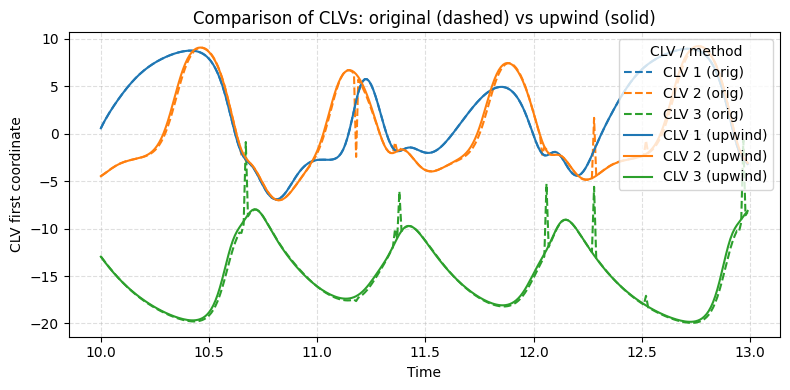

In [ ]:
plt.figure(figsize=(8, 4))

start, end = 1000, 1300

# plot original (dashed) and upwind (solid) CLV first-coordinate for three vectors
plt.plot(times[start:end], icle[start:end, 0], label='ICLE 1 (orig)', linestyle='--', color='C0')
plt.plot(times[start:end], icle[start:end, 1], label='ICLE 2 (orig)', linestyle='--', color='C1')
plt.plot(times[start:end], icle[start:end, 2], label='ICLE 3 (orig)', linestyle='--', color='C2')

plt.plot(times[start:end], icle_upwind[start:end, 0], label='ICLE 1 (upwind)', color='C0')
plt.plot(times[start:end], icle_upwind[start:end, 1], label='ICLE 2 (upwind)', color='C1')
plt.plot(times[start:end], icle_upwind[start:end, 2], label='ICLE 3 (upwind)', color='C2')

plt.xlabel('Time')
plt.ylabel('ICLE values')
plt.title('Comparison of ICLEs: original (dashed) vs upwind (solid)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='ICLE / method', loc='upper right')
plt.tight_layout()
plt.show()